## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


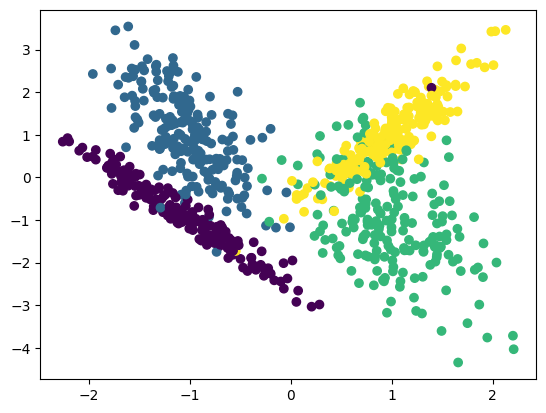

In [2]:
dataset = {}
X_all, y_all = make_classification(n_samples=1000, n_features=2, n_classes=4 , n_clusters_per_class=1, n_informative=2, n_redundant=0)
train_input, test_input, train_label, test_label = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

Train KAN

In [3]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.88e-01 | test_loss: 4.05e-01 | reg: 3.98e+00 | : 100%|█| 20/20 [00:07<00:00,  2.72it

saving model version 0.1


(0.856249988079071, 0.8949999809265137)

Automatic symbolic regression

In [4]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.944773256778717, c=1
fixing (0,1,0) with sin, r2=0.9993762373924255, c=2
saving model version 0.2


0.8901*x_1 + 0.7334*sin(0.589*x_2 - 5.9951) + 1.3603

How accurate is this formula?

In [5]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.7887, device='cuda:0')
test acc of the formula: tensor(0.7800, device='cuda:0')


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 4, CrossEntropy loss). 

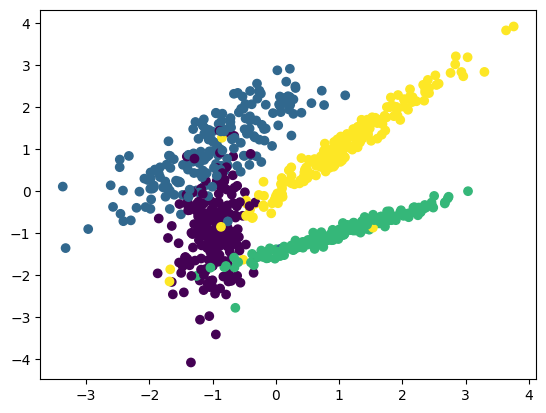

In [6]:

dataset = {}
X_all, y_all = make_classification(n_samples=1000, n_features=2, n_classes=4 , n_clusters_per_class=1, n_informative=2, n_redundant=0)
train_input, test_input, train_label, test_label = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [7]:
model = KAN(width=[2,4], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.52e-01 | test_loss: 5.11e-01 | reg: 5.01e+01 | : 100%|█| 20/20 [00:07<00:00,  2.56it

saving model version 0.1


Automatic symbolic regression

In [8]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

fixing (0,0,0) with sin, r2=0.9989619255065918, c=2
fixing (0,0,1) with x, r2=0.9868372082710266, c=1
fixing (0,0,2) with sin, r2=0.9974029064178467, c=2
fixing (0,0,3) with sin, r2=0.9991400241851807, c=2
fixing (0,1,0) with x, r2=0.5718395113945007, c=1
fixing (0,1,1) with sin, r2=0.9997233748435974, c=2
fixing (0,1,2) with sin, r2=0.9995526075363159, c=2
fixing (0,1,3) with sin, r2=0.9993406534194946, c=2
saving model version 0.2


In [9]:
formula1, formula2, formula3, formula4 = model.symbolic_formula()[0]
print(ex_round(formula1, 4))
print(ex_round(formula2, 4))
print(ex_round(formula3, 4))
print(ex_round(formula4, 4))


ValueError: too many values to unpack (expected 2)

In [ ]:
print(train_acc())
print(test_acc())

How accurate is this formula?

In [ ]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))